Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                        

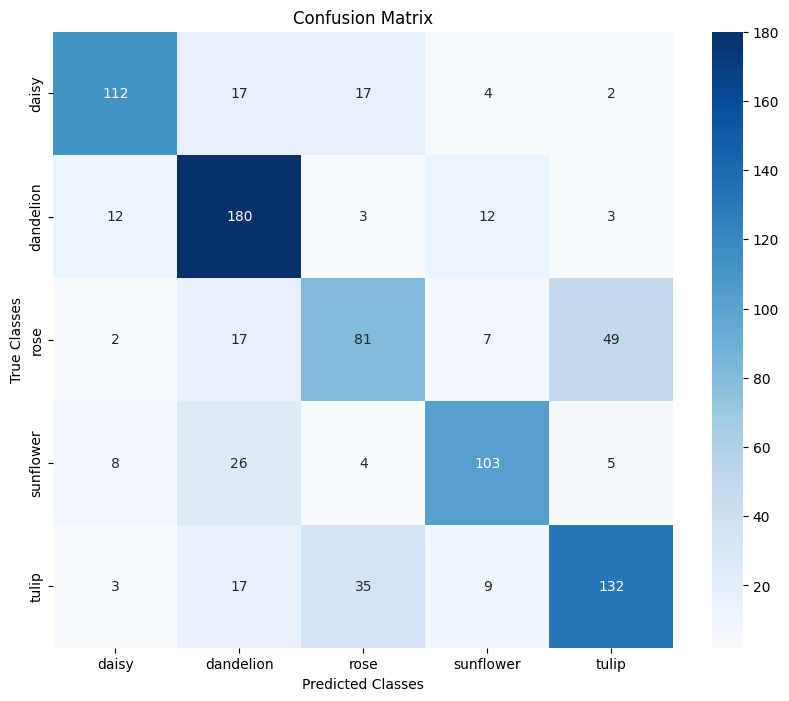

In [6]:
from google.colab import drive
drive.mount('/content/drive')

import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define your base directory where the dataset is located
base_dir = '/content/drive/MyDrive/Colab Notebooks/data/hw6_dataset/hw6_dataset/hw6_dataset'

# Set up the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split the data into training and validation sets
)

# Make sure not to apply data augmentation to validation data
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load the images and apply the transformations
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(256, 256),  # Size of your input images
    batch_size=32,
    class_mode='categorical',  # Because you have more than two classes
    subset='training'  # Set as training data
)

validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Set as validation data
    shuffle=False  # Important for proper label matching
)

# Define your CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), input_shape=(256, 256, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Output layer with 5 classes
])

model.summary()

# Compile your model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Calculate the correct steps per epoch
steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = math.ceil(validation_generator.samples / validation_generator.batch_size)

# Fit the model to the data
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,  # Number of batches per epoch
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps,  # Number of batches for validation
    callbacks=[early_stopping]
)

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(
    validation_generator,
    steps=validation_steps
)
print(f'Validation loss: {val_loss}')
print(f'Validation accuracy: {val_accuracy}')

# Reset the validation generator
validation_generator.reset()

# Get the predictions from the model using the generator
predictions = model.predict(
    validation_generator,
    steps=validation_steps
)

# 모델을 평가하기 전에 validation_generator를 통해 true_classes를 얻습니다.
true_classes = validation_generator.classes

# 예측을 수행합니다.
# 가정: 'predictions'는 이미 모델로부터 얻은 예측 결과를 담고 있습니다.
predicted_classes = np.argmax(predictions, axis=1)

# train_generator에서 class_indices를 가져와서 클래스 레이블 리스트를 생성합니다.
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())  # 클래스 레이블을 리스트로 변환

# Confusion matrix를 계산합니다.
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Confusion matrix를 시각화합니다.
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()

